In [1]:
import bz2
import json
import io
import ipaddress
import logging

import pandas as pd
import pytricia
import requests

from typing import NamedTuple, Optional, Set

from pandas.api.types import CategoricalDtype
from pandas.core.series import Series

LOG = logging.getLogger(__name__)
LOG.setLevel(logging.DEBUG)

In [2]:
class RouteOriginAuthorization(NamedTuple):
    asn: int
    prefix: str
    max_length: int

    prefix_length: Optional[int] = None

In [3]:
# https://www.ris.ripe.net/dumps/riswhoisdump.IPv4.gz
# https://www.ris.ripe.net/dumps/riswhoisdump.IPv6.gz
ris_v4_gz = requests.get("https://www.ris.ripe.net/dumps/riswhoisdump.IPv4.gz").content
ris_v6_gz = requests.get("https://www.ris.ripe.net/dumps/riswhoisdump.IPv6.gz").content

def read_ris_dump(url: str) -> pd.DataFrame:
    # Get file, accept that there are comment lines in there
    df = pd.read_csv(url,
                     compression='gzip',
                     sep="\t",
                     names=["origin", "prefix", "seen_by_peers"]
    )
    
    if df.origin.str.startswith('{').any():
        LOG.error("RIS dump contains row(s) with AS_SET! These will never be RPKI valid (https://tools.ietf.org/html/rfc6907#section-7.1.8)")
    # select the rows that do not have the '%' prefix
    df = df[~df.origin.str.startswith('%')].copy()
    
    # separate prefix length
    df['prefix_length'] = df.prefix.map(lambda p: ipaddress.ip_network(p).prefixlen)
    
    return df

In [4]:
# Atlas Probe archive
atlas_probes_bz2 = requests.get("https://ftp.ripe.net/ripe/atlas/probes/archive/meta-latest").content
atlas_probes = pd.DataFrame(json.loads(bz2.decompress(atlas_probes_bz2))['objects'])

In [5]:
ris_v4 = read_ris_dump("https://www.ris.ripe.net/dumps/riswhoisdump.IPv4.gz")
ris_v6 = read_ris_dump("https://www.ris.ripe.net/dumps/riswhoisdump.IPv6.gz")

RIS dump contains row(s) with AS_SET! These will never be RPKI valid (https://tools.ietf.org/html/rfc6907#section-7.1.8)
RIS dump contains row(s) with AS_SET! These will never be RPKI valid (https://tools.ietf.org/html/rfc6907#section-7.1.8)


In [6]:
# Get RPKI valids
validated_objects = requests.get("https://rpki-validator.ripe.net/api/objects/validated").json()
rpki_roas = pd.DataFrame(validated_objects['data']['roas'])
# And add address family
rpki_roas['af'] = af = rpki_roas.prefix.map(lambda p: ipaddress.ip_network(p).version)
# And prefix length (to chart later)
rpki_roas['prefix_length'] = af = rpki_roas.prefix.map(lambda p: ipaddress.ip_network(p).prefixlen)

In [7]:
rpki_roas_v4 = rpki_roas[rpki_roas.af == 4]
rpki_roas_v6 = rpki_roas[rpki_roas.af == 6]

In [8]:
class RouteOriginAuthorizationLookup:
    """
    Build patricia tries for storing ROAs.

    The entries of the patricia tries will be a set of RouteOriginAuthorization that are an
    exact match for the prefix of a key.

    To lookup all applicable ROAs for a value, first retrieve the most specific entry,
    followed by looking up the parents.
    """
    trie: pytricia.PyTricia
        
    def __init__(self, data: pd.DataFrame) -> None:
        assert data.af.nunique() == 1
        length = 128 if data.af.unique()[0] == 6 else 32
        
        self.trie = pytricia.PyTricia(length)
        data.apply(self.__build_trie, axis=1)
        
    def __build_trie(self, row: Series) -> None:
        if not self.trie.has_key(row.prefix):
            # Add entry
            self.trie[row.prefix] = set()
            
        self.trie[row.prefix].add(
            RouteOriginAuthorization(row.asn, row.prefix, row.maxLength, row.prefix_length)
        )
        
    def lookup_roas(self, prefix) -> Set[RouteOriginAuthorization]:
        res = set()
        
        try:
            last_prefix = prefix
            while last_prefix is not None:
                res.update(self.trie[last_prefix])
                last_prefix = self.trie.parent(last_prefix)
        except KeyError:
            # Either the initial value was not found, or we traversed parents
            # until we did not find another.
            pass
        
        return res

roa_lookup_v4 = RouteOriginAuthorizationLookup(rpki_roas_v4)
roa_lookup_v6 = RouteOriginAuthorizationLookup(rpki_roas_v6)

In [9]:
# This prefix has a ROA for a less specific
roa_lookup_v4.lookup_roas('1.6.108.0/24')

{RouteOriginAuthorization(asn='9583', prefix='1.6.108.0/22', max_length=22, prefix_length=22),
 RouteOriginAuthorization(asn='9583', prefix='1.6.108.0/24', max_length=24, prefix_length=24)}

### Data has been loaded

Spot-check a sample from the roas in the prefix tries for both address families. Filter so it is a sample not from the most-common prefix length.

Starting with IPv4:

In [10]:
rpki_roas_v4.describe()

,maxLength,af,prefix_length
count,187693.000000,187693.0,187693.000000
mean,23.278726,4.0,22.620918
std,2.108451,0.0,2.248629
min,10.000000,4.0,9.000000
25%,23.000000,4.0,22.000000
50%,24.000000,4.0,24.000000
75%,24.000000,4.0,24.000000
max,32.000000,4.0,32.000000


In [11]:
sample = rpki_roas_v4[rpki_roas_v4.prefix_length != 24].sample(5).reset_index()
display(sample)

,index,asn,prefix,maxLength,af,prefix_length
0,88549,37340,197.242.108.0/23,23,4,23
1,149315,31638,93.115.170.0/23,23,4,23
2,182703,51167,144.91.86.0/23,32,4,23
3,180731,50563,45.8.76.0/23,23,4,23
4,103743,1199,145.102.136.0/22,22,4,22


In [12]:
roa_lookup_v4.trie[sample.prefix[0]]

{RouteOriginAuthorization(asn='37340', prefix='197.242.108.0/23', max_length=23, prefix_length=23)}

The printed entry should match the `prefix_length` in the top row of the table.

<AxesSubplot:ylabel='Frequency'>

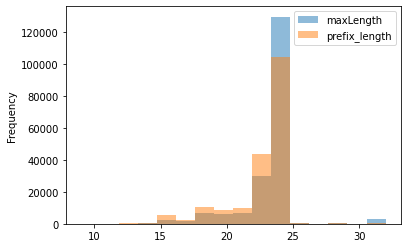

In [13]:
rpki_roas_v4[['maxLength', 'prefix_length']].plot.hist(
    by='maxLength',
    bins=16,
    alpha=0.5
)

And now IPv6, again skipping what is likely the most common prefix_length

In [14]:
rpki_roas_v6.describe()

,maxLength,af,prefix_length
count,31927.000000,31927.0,31927.000000
mean,43.831146,6.0,41.246281
std,10.689522,0.0,8.413041
min,19.000000,6.0,19.000000
25%,36.000000,6.0,32.000000
50%,48.000000,6.0,44.000000
75%,48.000000,6.0,48.000000
max,128.000000,6.0,128.000000


In [15]:
sample = rpki_roas_v6[rpki_roas_v6.prefix_length != 48].sample(5).reset_index()
display(sample)

,index,asn,prefix,maxLength,af,prefix_length
0,50788,64098,2400:1240:4800::/38,38,6,38
1,153169,34924,2a0f:5707:aa00::/44,48,6,44
2,39150,45224,2406:c00:a48::/46,46,6,46
3,109714,5610,2a02:9b8::/31,31,6,31
4,110707,6805,2a02:3102:8000::/33,39,6,33


In [16]:
roa_lookup_v6.trie[sample.prefix[0]]

{RouteOriginAuthorization(asn='135888', prefix='2400:1240:4800::/38', max_length=38, prefix_length=38),
 RouteOriginAuthorization(asn='64098', prefix='2400:1240:4800::/38', max_length=38, prefix_length=38)}

<AxesSubplot:ylabel='Frequency'>

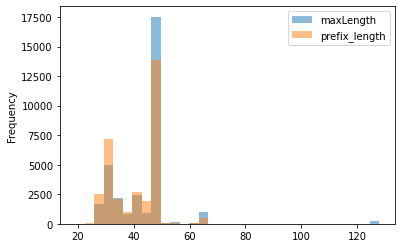

In [17]:
rpki_roas_v6[['maxLength', 'prefix_length']].plot.hist(
    by='maxLength',
    bins=32,
    alpha=0.5
)

All data has been collected.

In [18]:
ris_v4

,origin,prefix,seen_by_peers,prefix_length
16,174,0.0.0.0/0,5.0,0
17,55720,0.0.0.0/0,2.0,0
18,30823,0.0.0.0/0,1.0,0
19,3356,0.0.0.0/0,2.0,0
20,50628,0.0.0.0/0,2.0,0
...,...,...,...,...
1000064,63199,223.255.250.0/24,327.0,24
1000065,63199,223.255.251.0/24,327.0,24
1000066,58519,223.255.252.0/24,330.0,24
1000067,58519,223.255.253.0/24,330.0,24


In [32]:
def rpki_status_v4(ris_entry: Series) -> str:
    print(ris_entry)
    # Lookup entry in patricia trie
    roas = roa_lookup_v4.lookup_roas(ris_entry.prefix)
    if not roas:
        return 'unknown'
    
    # Match roas, to match, they need to:
    # * have the same AS as the ROA
    # * have a prefix length <= maxLength
    was_valid = False
    for roa in roas:
        print(roa)
        if roa.asn != ris_entry.origin:
            LOG.info("invalid as: %s ris origin: %d for %s", roa, ris_entry.origin, ris_entry.prefix)
        else:
            assert roa.prefix_length <= ris_entry.prefix_length
            if roa.max_length >= ris_entry.prefix_length:
                LOG.info("valid roa: %s for %s announced by %s", roa, ris_entry.prefix, ris_entry.origin)
                was_valid = True
            else:
                LOG.info("invalid length: %s does not match %s", ris_entry.prefix)
        
    return 'valid' if was_valid else 'invalid'

ris_v4.sample(1).apply(rpki_status_v4, axis=1)

origin                     55720
prefix           103.244.1.50/32
seen_by_peers                2.0
prefix_length                 32
Name: 369210, dtype: object
RouteOriginAuthorization(asn='55720', prefix='103.244.1.0/24', max_length=24, prefix_length=24)


369210    invalid
dtype: object